# Preprocessing
Este archivo busca que los datos sean consistentes, limpios y utilizables.

La clase TitanicDatasetPreprocessor nos sirve para preprocesar los datos, ubicados en el dataframe del titanic llamado df, lo cual no sirve para alimentar modelos de machine learning a través de tres/3 funcionalidades que viene siendo:

In [1]:
#%pip install pandas
#%pip install numpy
#%pip install matplotlib
#%pip install seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# entrenando, las advertencias eran un mar en la pantalla
import warnings
warnings.filterwarnings('ignore', category=UserWarning)


df = pd.read_csv("../data/raw/Titanic-Dataset.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
##%pip install scikit-learn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

class TitanicDatasetPreprocessor:
    """
    Preprocesador para el dataset del Titanic:
    - Imputa valores faltantes
    - Escala columnas numéricas
    - One-hot encodea columnas categóricas
    """
    def __init__(self):
        self.pipeline = None
        self.output_feature_names_ = None

        # Columnas categóricas y numéricas a procesar
        self.categorical_cols = [
            'Sex', 'Pclass',
            'Title', 'AgeGroup', 'CabinDeck'
        ]
        self.numerical_cols = [
            'Age', 'SibSp', 'Parch', 'FamilySize', 'IsAlone', 'FarePerPerson',
        ]
        
    def fit(self, X, y=None):
        """
        Ajusta el pipeline de transformación a los datos.
        """
        X_proc = X.copy()

        # Filtramos columnas que existen
        num_cols_pipeline = [c for c in self.numerical_cols if c in X_proc.columns]
        cat_cols_pipeline = [c for c in self.categorical_cols if c in X_proc.columns]

        # Pipeline para numéricas
        num_transformer = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ])

        # Pipeline para categóricas
        cat_transformer = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ])

        # ColumnTransformer
        self.pipeline = ColumnTransformer(transformers=[
            ("num", num_transformer, num_cols_pipeline),
            ("cat", cat_transformer, cat_cols_pipeline)
        ], remainder='drop')

        # Fit del pipeline
        X_proc_for_pipeline = X_proc[num_cols_pipeline + cat_cols_pipeline]
        self.pipeline.fit(X_proc_for_pipeline)

        # Guardamos nombres finales de columnas
        self.output_feature_names_ = (
            num_cols_pipeline +
            list(self.pipeline.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(cat_cols_pipeline))
        )
        return self

    def transform(self, X):
        """
        Transforma los datos usando el pipeline ajustado.
        """
        if self.pipeline is None:
            raise RuntimeError("Primero llama a fit() con los datos de entrenamiento.")

        X_proc = X.copy()

        num_cols_pipeline = [c for c in self.numerical_cols if c in X_proc.columns]
        cat_cols_pipeline = [c for c in self.categorical_cols if c in X_proc.columns]

        X_proc_for_pipeline = X_proc[num_cols_pipeline + cat_cols_pipeline]
        X_out = self.pipeline.transform(X_proc_for_pipeline)

        return pd.DataFrame(X_out, columns=self.output_feature_names_, index=X.index)

    def fit_transform(self, X, y=None):
        """
        Combina fit() y transform() en una sola llamada.
        """
        return self.fit(X, y).transform(X)



In [3]:
%run ./_02_feature_engineering.ipynb


# Aplicas todas las funciones al DataFrame original
df_fe = df.copy()
df_fe = title_feature(df_fe)
df_fe = family_size_feature(df_fe)
df_fe = is_alone_feature(df_fe)
df_fe = age_group_feature(df_fe)
df_fe = fare_per_person_feature(df_fe)
df_fe = cabin_deck_feature(df_fe)
df_fe = cabin_known_feature(df_fe)
df_fe = ticket_frequency_feature(df_fe)
df_fe = name_length_feature(df_fe)
df_fe = has_cabin_neighbor_feature(df_fe)
df_fe = ticket_prefix_feature(df_fe)
df_fe.head()

# Creamos una instancia de TitanicDatasetPreprocessor y realizamos un fit para los datos
preprocessor = TitanicDatasetPreprocessor()
preprocessor.fit(df_fe)

# Ahora, usamos TitanicDatasetPreprocessor ya con los parametros de transformación para utilizar
# el metodo de transformación para ver el output del pipeline
df_transformed_correct = preprocessor.transform(df_fe.copy())

# Finalmente, desplegamos el shape de los datos transformados y  los primeros cinco renglones
print("Shape de los datos transformados:", df_transformed_correct.shape)
print("\nPrimeros 5 renglones de los datos transformados:")
display(df_transformed_correct.head())

VERIFICACIÓN DE VALORES ÚNICOS Y CONTEO para 'Title':
Title
Mr        517
Miss      184
Mrs       126
Master     40
Rare       23
Ms          1
Name: count, dtype: int64

VERIFICACIÓN DE VALORES ÚNICOS Y CONTEO para 'AgeGroup':
AgeGroup
Adult                  752
Child                   68
Adolescent/Teenager     45
Senior                  26
Name: count, dtype: int64

VERIFICACIÓN DE VALORES ÚNICOS Y CONTEO para 'CabinDeck':
CabinDeck
Unknown    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: count, dtype: int64

VERIFICACIÓN DE VALORES ÚNICOS Y CONTEO para 'CabinKnown':
CabinKnown
0    687
1    204
Name: count, dtype: int64

VERIFICACIÓN DE LA DISTRIBUCIÓN para 'CabinKnown':
count    891.000000
mean       0.228956
std        0.420397
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: CabinKnown, dtype: float64

VERIFICACIÓN DE VALORES ÚNICOS Y CONTE

,Age,SibSp,Parch,FamilySize,IsAlone,FarePerPerson,Sex_female,Sex_male,Pclass_1,Pclass_2,...,AgeGroup_Senior,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinDeck_Unknown
0,-0.565736,0.432793,-0.473674,0.059160,-1.231645,-0.454798,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.663861,0.432793,-0.473674,0.059160,-1.231645,0.438994,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.258337,-0.474545,-0.473674,-0.560975,0.811922,-0.334757,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.433312,0.432793,-0.473674,0.059160,-1.231645,0.185187,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.433312,-0.474545,-0.473674,-0.560975,0.811922,-0.331267,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
df_transformed_correct.columns

Index(['Age', 'SibSp', 'Parch', 'FamilySize', 'IsAlone', 'FarePerPerson',
       'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Ms',
       'Title_Rare', 'AgeGroup_Adolescent/Teenager', 'AgeGroup_Adult',
       'AgeGroup_Child', 'AgeGroup_Senior', 'CabinDeck_A', 'CabinDeck_B',
       'CabinDeck_C', 'CabinDeck_D', 'CabinDeck_E', 'CabinDeck_F',
       'CabinDeck_G', 'CabinDeck_T', 'CabinDeck_Unknown'],
      dtype='object')

## Preparación dataset

In [5]:
from sklearn.model_selection import train_test_split
y = df_fe["Survived"]
X = df_fe.drop(columns=["Survived"])

preprocessor = TitanicDatasetPreprocessor()
X_transformed = preprocessor.fit_transform(X)

X_df = X_transformed
print("Shape transformado:", X_df.shape)
X_df.head()

# split de datos (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=42, stratify=y
)

imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


print(f"\nNumber of NaNs in X_train before fitting model:\n{np.isnan(X_train).sum()}")
print(f"\nNumber of NaNs in X_test before predicting:\n{np.isnan(X_test).sum()}")


Shape transformado: (891, 30)

Number of NaNs in X_train before fitting model:
0

Number of NaNs in X_test before predicting:
0


## Verificar la transformación

In [6]:
display(X_df.head())

print("Original DataFrame columns:\n", df.columns.tolist())
print("\nTransformed DataFrame columns:\n", X_df.columns.tolist())


print("\nTransformed DataFrame info:")
X_df.info()


,Age,SibSp,Parch,FamilySize,IsAlone,FarePerPerson,Sex_female,Sex_male,Pclass_1,Pclass_2,...,AgeGroup_Senior,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinDeck_Unknown
0,-0.565736,0.432793,-0.473674,0.059160,-1.231645,-0.454798,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.663861,0.432793,-0.473674,0.059160,-1.231645,0.438994,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.258337,-0.474545,-0.473674,-0.560975,0.811922,-0.334757,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.433312,0.432793,-0.473674,0.059160,-1.231645,0.185187,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.433312,-0.474545,-0.473674,-0.560975,0.811922,-0.331267,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Original DataFrame columns:
 ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'AgeGroup', 'CabinDeck', 'CabinKnown', 'LastName', 'FamilySize', 'HasFamilyOnSameDeck']

Transformed DataFrame columns:
 ['Age', 'SibSp', 'Parch', 'FamilySize', 'IsAlone', 'FarePerPerson', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Ms', 'Title_Rare', 'AgeGroup_Adolescent/Teenager', 'AgeGroup_Adult', 'AgeGroup_Child', 'AgeGroup_Senior', 'CabinDeck_A', 'CabinDeck_B', 'CabinDeck_C', 'CabinDeck_D', 'CabinDeck_E', 'CabinDeck_F', 'CabinDeck_G', 'CabinDeck_T', 'CabinDeck_Unknown']

Transformed DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age                         

### Modelos y Parámetros

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# con este diccionario, podemos probar todos los parametros usando RandomizedSearchCV
models_and_params = [
    # elasticnet es el unico parametro que usa l1_ratio
    {
      'name': 'Logistic Regression (l1/l2)',
      'model': LogisticRegression(max_iter=200, solver="saga"),
      'params': {
          'C': [0.001, 0.01, 0.1, 1, 10, 100],
          'penalty': ['l1', 'l2'],
          'class_weight': [None, 'balanced']
      }
    },
    {
      'name': 'Logistic Regression (elasticnet)',
      'model': LogisticRegression(max_iter=200, solver="saga"),
      'params': {
          'C': [0.001, 0.01, 0.1, 1, 10, 100],
          'penalty': ['elasticnet'],
          'l1_ratio': [0, 0.5, 1],
          'class_weight': [None, 'balanced']
      }
    },
    {
        'name': 'Random Forest',
        'model': RandomForestClassifier(random_state=42, oob_score=True),
        'params': {
            'n_estimators': [100, 200, 300, 500],
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', 0.3, 0.5]
        }
    },
    {
        'name': 'XGBoost',
        'model': XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        ),
        'params': {
            'learning_rate': [0.01, 0.05, 0.1, 0.3],
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'subsample': [0.7, 0.8, 0.9, 1.0],
            'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
            'gamma': [0, 0.1, 0.3, 0.5]
        }
    },
    {
        'name': 'SVM',
        'model': SVC(probability=True),
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['rbf', 'poly', 'sigmoid'],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
            'degree': [2, 3, 4]
        }
    }
]

### Entrenamiento y optimización

In [9]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

best_models = {}
cv_results = {}

# 5-fold, como dicen las instrucciones
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# optimización
for item in models_and_params:
    print(f"--- Tuning {item['name']} ---")
    grid_search = GridSearchCV(
        item['model'],
        item['params'],
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        refit=True,
        return_train_score=True,
    )
    grid_search.fit(X_train, y_train)
    best_models[item['name']] = grid_search.best_estimator_
    cv_results[item['name']] = grid_search.cv_results_
    print(f"Best params: {grid_search.best_params_}")
    print(f"Best ROC-AUC: {grid_search.best_score_}")
    print("-" * 30)


--- Tuning Logistic Regression (l1/l2) ---
Best params: {'C': 1, 'class_weight': None, 'penalty': 'l1'}
Best ROC-AUC: 0.8679836505071614
------------------------------
--- Tuning Logistic Regression (elasticnet) ---
Best params: {'C': 1, 'class_weight': None, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
Best ROC-AUC: 0.8679848907043265
------------------------------
--- Tuning Random Forest ---
Best params: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best ROC-AUC: 0.8911589114763097
------------------------------
--- Tuning XGBoost ---
Best params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.7}
Best ROC-AUC: 0.8929996543280243
------------------------------
--- Tuning SVM ---
Best params: {'C': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
Best ROC-AUC: 0.8643934116504649
------------------------------


### Evaluación

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
# evaluación
metrics_results = {}

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    print("-" * 30)

    metrics_results[name] = {
        "roc_auc": roc_auc_score(y_test, y_proba),
        "confusion_matrix": confusion_matrix(y_test, y_pred).tolist()
    }


--- Logistic Regression (l1/l2) ---
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       110
           1       0.81      0.75      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179

[[98 12]
 [17 52]]
ROC-AUC: 0.8778656126482214
------------------------------

--- Logistic Regression (elasticnet) ---
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       110
           1       0.81      0.75      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179

[[98 12]
 [17 52]]
ROC-AUC: 0.8773386034255598
------------------------------

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.81      0.86

##### Interpretacion
El mejor ROC-AUC es de la Regresión Logística, en cualquiera de las dos variantes (l1 o 0.5 l1), pero el resto de los modelos quedan cerca.

Todos los modelos terminaron con recall alto para la *no* supervivencia. Es decir, todos los modelos son buenos para detectar quienes *no* sobrevivirian.
Por el otro lado, es claramente más difícil atinar a quienes sobrevivirían, pero una vez más el mejor recall es de la regresión Logística.
(El SVM quedó muy cerca, la diferencia fue una sola predicción)

El Random Forest y Gradient Boosting son los modelos que más seguido dieron falsos negativos a la supervivencia.

En este análisis inicial de los resultados, y considerando que nuestro objetivo es predecir quienes sobreviven, parece ser el modelo de Regresión Logística el que mejor se adaptó al dataset.


## Modelos, Análisis y su Feature Importance

In [11]:
feature_names = X_df.columns.tolist()
print(feature_names)

['Age', 'SibSp', 'Parch', 'FamilySize', 'IsAlone', 'FarePerPerson', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Ms', 'Title_Rare', 'AgeGroup_Adolescent/Teenager', 'AgeGroup_Adult', 'AgeGroup_Child', 'AgeGroup_Senior', 'CabinDeck_A', 'CabinDeck_B', 'CabinDeck_C', 'CabinDeck_D', 'CabinDeck_E', 'CabinDeck_F', 'CabinDeck_G', 'CabinDeck_T', 'CabinDeck_Unknown']


### Modelo de regresión logística
Aunque separamos los modelos por `penalty` (l1/l2 y eslasticnet), los dos modelos modelos tuvieron la misma eficacia, así que nos quedaremos con el modelo Lasso (penalty l1).

In [26]:
best_log_reg_model = best_models['Logistic Regression (l1/l2)']

log_reg_importance = np.abs(best_log_reg_model.coef_[0])
importance_df_lr = pd.DataFrame({'Feature': feature_names, 'Importance': log_reg_importance})
importance_df_lr = importance_df_lr.sort_values('Importance', ascending=False)
display(importance_df_lr.head(10))

,Feature,Importance
11,Title_Master,1.377055
13,Title_Mr,1.244537
6,Sex_female,1.150582
25,CabinDeck_E,0.826376
24,CabinDeck_D,0.811097
29,CabinDeck_Unknown,0.806421
10,Pclass_3,0.737894
14,Title_Mrs,0.517542
3,FamilySize,0.507862
7,Sex_male,0.436385


In [13]:
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [36]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

log_reg = best_models["Logistic Regression (l1/l2)"]  # o (l1/l2)

#### Odds ratio

In [37]:
coef = log_reg.coef_[0]
features = X_train.columns
odds_ratios = np.exp(coef)

coef_df = pd.DataFrame({
    "Variable": features,
    "Coeficiente": coef,
    "Odds Ratio": odds_ratios
}).sort_values(by="Odds Ratio", ascending=False)

print("Principales Variables por Odds Ratio:")
print(coef_df.head(15))
print("\nVariables menos importantes por Odds Ratio:")
print(coef_df.tail(10))

Principales Variables por Odds Ratio:
                        Variable  Coeficiente  Odds Ratio
11                  Title_Master     1.377055    3.963214
6                     Sex_female     1.150582    3.160031
25                   CabinDeck_E     0.826376    2.285024
24                   CabinDeck_D     0.811097    2.250375
14                     Title_Mrs     0.517542    1.677898
8                       Pclass_1     0.365828    1.441708
5                  FarePerPerson     0.179805    1.196984
17  AgeGroup_Adolescent/Teenager     0.070326    1.072858
20               AgeGroup_Senior     0.000000    1.000000
21                   CabinDeck_A     0.000000    1.000000
19                AgeGroup_Child     0.000000    1.000000
15                      Title_Ms     0.000000    1.000000
9                       Pclass_2     0.000000    1.000000
12                    Title_Miss     0.000000    1.000000
26                   CabinDeck_F     0.000000    1.000000

Variables menos importantes por O

Como se ha observado en las entregas anteriores, ser un niño y/o ser mujer contribuye enormemente a la supervivencia. El modelo de regresión Logística encuentra como el mayor indicador (coeficiente) de supervivencia el ser un niño varón (título "Master"), teniendo casi 4 veces las probabilidad de sobrevivir que aquellos con otros títulos.

De manera similar a ser niño varón, ser mujer es el segundo mejor indicador de que una persona sobreviviría, lo cual confirma nuestras hipótesis desde la primera entrega y observaciones del dataset.

Finalemente, la clase del boleto también se refleja en el modelo con la primera clase siendo una mejor oportunidad, ningún aporte al modelo para la segunda clase, y finalmente la tercera clase refleja menor probabilidad de sobrevivir. Esto también concuerdo con nuestros análisis anteriores, en los que pudimos observar que en todos los géneros, la tercera clase sufrió desproporcionadamente más perdidas.

#### Curvas de Regularizacion

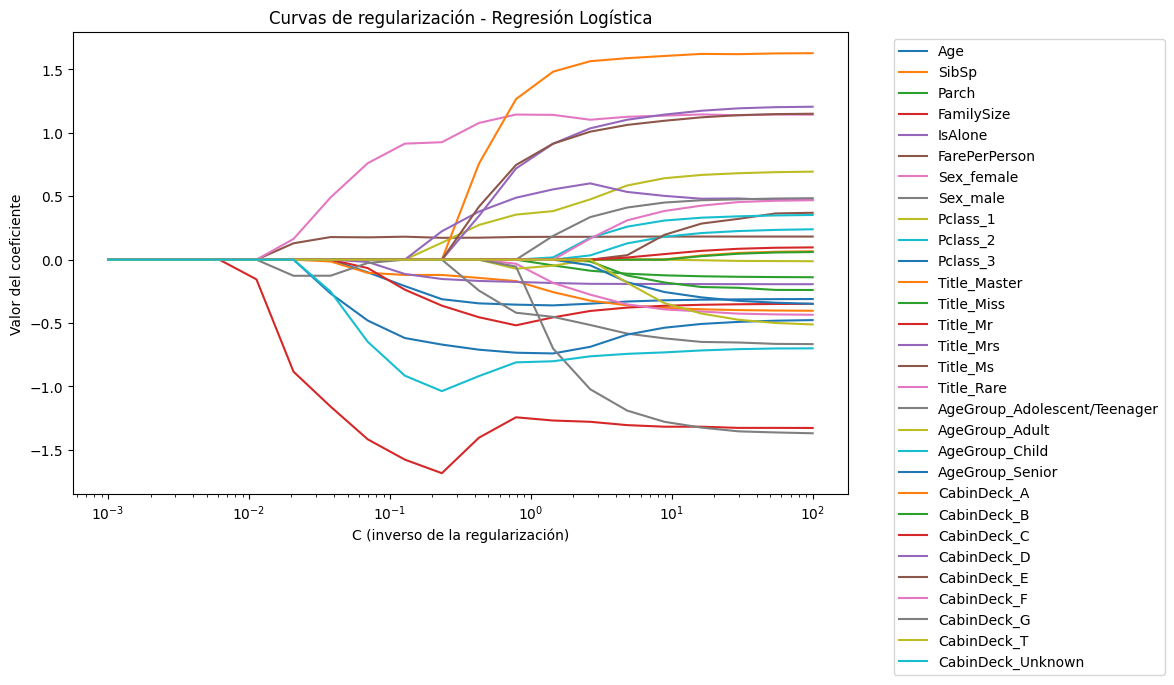

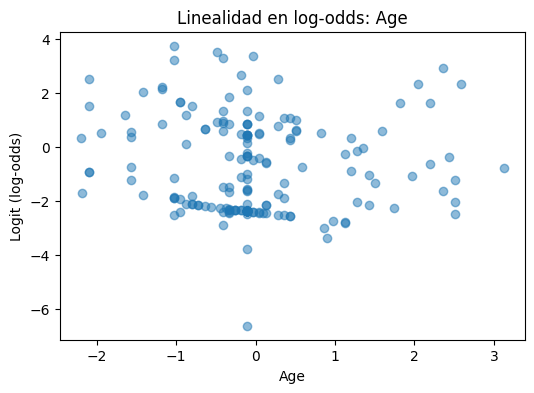

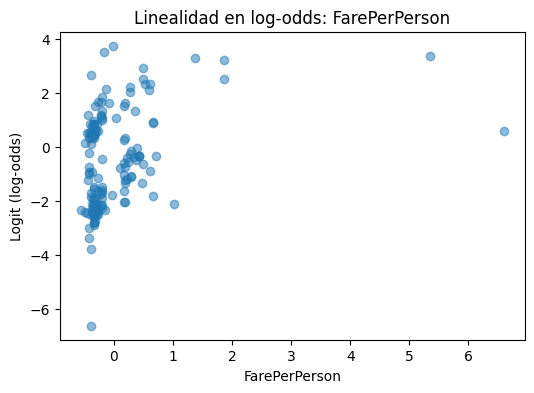

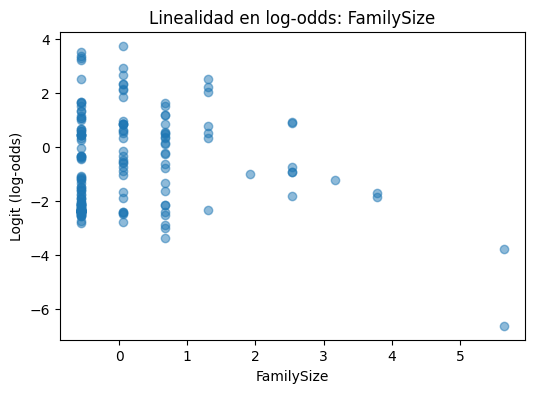

In [45]:
Cs = np.logspace(-3, 2, 20)
coefs = []
for C in Cs:
    model = LogisticRegression(
        penalty=log_reg.penalty,
        solver=log_reg.solver,
        l1_ratio=getattr(log_reg, "l1_ratio", None),
        C=C,
        max_iter=200
    )
    model.fit(X_train, y_train)
    coefs.append(model.coef_[0])

coefs = np.array(coefs)

plt.figure(figsize=(10,6))
for i in range(coefs.shape[1]):
    plt.plot(Cs, coefs[:, i], label=features[i])
plt.xscale("log")
plt.xlabel("C (inverso de la regularización)")
plt.ylabel("Valor del coeficiente")
plt.title("Curvas de regularización - Regresión Logística")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

# Probabilidades predichas por el modelo
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

logit = np.log(y_pred_proba / (1 - y_pred_proba))

# Graficar logit con cada variable numérica
num_vars = ["Age", "FarePerPerson", "FamilySize"]

for var in num_vars:
    plt.figure(figsize=(6,4))
    plt.scatter(X_test[var], logit, alpha=0.5)
    plt.xlabel(var)
    plt.ylabel("Logit (log-odds)")
    plt.title(f"Linealidad en log-odds: {var}")
    plt.show()

### Modelo Random Forest

In [15]:
best_rf_model = best_models['Random Forest']

rf_importance = best_rf_model.feature_importances_
importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importance})
importance_df_rf = importance_df_rf.sort_values('Importance', ascending=False)
display(importance_df_rf.head(10)) # Display top 10 features

,Feature,Importance
13,Title_Mr,0.197806
5,FarePerPerson,0.184243
7,Sex_male,0.127186
6,Sex_female,0.119990
0,Age,0.112337
10,Pclass_3,0.061834
3,FamilySize,0.050574
29,CabinDeck_Unknown,0.039285
1,SibSp,0.019992
16,Title_Rare,0.012494


In [47]:
from sklearn.inspection import permutation_importance
rf = best_models["Random Forest"]

# importancia de variables (Gini)
importances = rf.feature_importances_
feat_imp = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia (Gini)": importances
}).sort_values(by="Importancia (Gini)", ascending=False)

print("Importancia de variables (Gini):")
print(feat_imp.head(15))

# importancia por permutación
perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
perm_imp = pd.DataFrame({
    "Variable": X_test.columns,
    "Importancia Media": perm.importances_mean,
    "Desviación": perm.importances_std
}).sort_values(by="Importancia Media", ascending=False)

print("\nImportancia de variables (Permutación):")
print(perm_imp.head(10))

# profundidad efectiva de árboles
depths = [estimator.tree_.max_depth for estimator in rf.estimators_]
print(f"\nProfundidad promedio de árboles: {np.mean(depths):.2f}")
print(f"Profundidad máxima: {np.max(depths)}")

# OOB score
print(f"Puntaje OOB: {rf.oob_score_:.4f}")

Importancia de variables (Gini):
             Variable  Importancia (Gini)
13           Title_Mr            0.197806
5       FarePerPerson            0.184243
7            Sex_male            0.127186
6          Sex_female            0.119990
0                 Age            0.112337
10           Pclass_3            0.061834
3          FamilySize            0.050574
29  CabinDeck_Unknown            0.039285
1               SibSp            0.019992
16         Title_Rare            0.012494
14          Title_Mrs            0.010091
8            Pclass_1            0.009279
12         Title_Miss            0.007565
9            Pclass_2            0.007118
2               Parch            0.006634

Importancia de variables (Permutación):
           Variable  Importancia Media  Desviación
13         Title_Mr       3.854749e-02    0.020366
0               Age       2.290503e-02    0.010133
10         Pclass_3       2.234637e-02    0.010600
11     Title_Master       5.027933e-03    0.001676

#### Gini
De manera peculiar, el modelo de Random Forest considera el título de "Mister" como la información más importante para la predicción. Pero visto desde la perspectiva de la información que incluye ese título, un hombre que ya no es un niño, está alineado a nuestras hipótesis y análisis previo.

El resto de las variables siguen siendo las mismas que esperabamos, con gran peso para la edad, el sexo, la tarifa por persona (que correlaciona fuertemente con la clase del boleto).
También podemos ver peso en algunas variables que no hemos considerado para causalidad, como `CabinDeck_Unknown`, pero estas las podemos atribuir a ruido o a una correlación con otras variables.

#### Permutación
En la importancia por permutación, el patrón cambia un poco. La edad y ser de tercera clase aparecen como variables con impacto directo en la métrica, junto con el título de "Mister". Esto refuerza la idea de que el modelo está capturando la misma idea que tenenmos: hombres adultos de tercera clase y mayor edad tenían menos probabilidad de sobrevivir.

El hecho de que variables como `Sex_female` o `Sex_male` pierdan relevancia en este análisis se puede explicar porque la información de género ya está contenida en los títulos. Es decir, el modelo no necesita usar directamente el sexo si ya lo correlaciona a variables con más información.

#### Profundidad y OOB
Los árboles alcanzan una profundidad promedio de 13, lo que podría ser mucho para el dataset, indicando overfitting o ruido por las variables elegidas. Sin embargo, el puntaje OOB de 0.8469 es consistente con el rendimiento en test, sugiere que no hay mucho sobreajuste. 

Como vimos en las matrizes de confusión, el modelo es más complejo que la regresión logística, pero no más preciso en este conjunto de datos.

### Modelo Gradient Boosting

#### Early Stopping + Curvas de aprendizaje

In [64]:
from xgboost import XGBClassifier

params_keys = {
    'learning_rate',
    'n_estimators',
    'max_depth',
    'subsample',
    'colsample_bytree',
    'gamma'
}

# Reentrenar XGBoost con early stopping
# tengo que sacar los valores para los que se optimizó anteriormente, para ahora entrenar
# pero con early stopping. No se puede hacer early_stopping con GridSearchCV
todos_params = best_models["XGBoost"].get_params()
filtrados_params = {k: todos_params[k] for k in params_keys if k in todos_params}

xgb_final = XGBClassifier(
    **filtrados_params,
    early_stopping_rounds=30,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb_final.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

print("Mejor iteración:", xgb_final.best_iteration)
print("Mejor score de validación:", xgb_final.best_score)

# Reemplazo el modelo con el nuevo reentrenado
# no se si esto era esperado... pero me hace mas sentido que usar un diferente modelo solo para una de los analisis.
best_models["XGBoost"] = xgb_final

Mejor iteración: 80
Mejor score de validación: 0.44053291138157497


Los hiperparámetros para los que se optimizó sin early_stop fue de 100, el valor más bajo de entre las opciones. Ahora con early stiop, solamente necesitó 80 iteraciones el modelo para llegar al estado en donde no mejoraba contra las pruebas. La rápida convergencia es una buena señal.

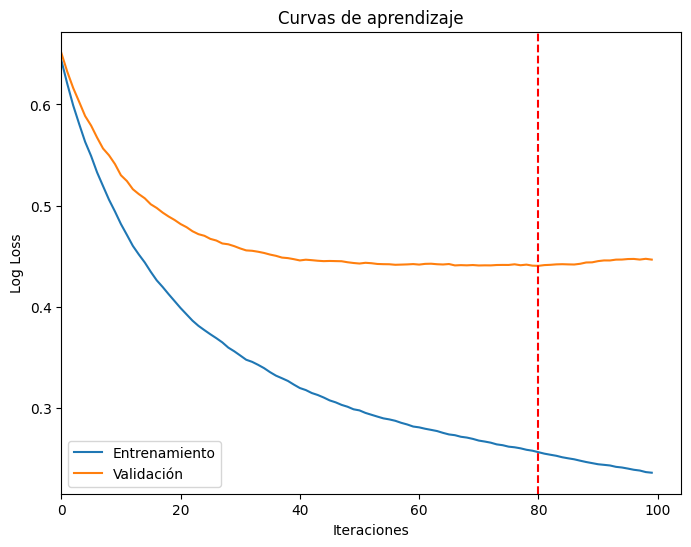

In [62]:
results = xgb_final.evals_result()
plt.figure(figsize=(8,6))
plt.plot(results['validation_0']['logloss'], label="Entrenamiento" )
if 'validation_1' in results:
    plt.plot(results['validation_1']['logloss'], label="Validación")
plt.xlabel("Iteraciones")
plt.ylabel("Log Loss")
plt.axvline(x=80, color="red", ls="--")
plt.xlim(left=0)
plt.title("Curvas de aprendizaje")
plt.legend()
plt.show()

#### Importancia de variables

In [65]:
gb_importance = xgb_final.feature_importances_
importance_df_gb = pd.DataFrame({'Feature': feature_names, 'Importance': gb_importance})
importance_df_gb = importance_df_gb.sort_values('Importance', ascending=False)
display(importance_df_gb.head(10))

xgb_importance = xgb_final.get_booster().get_score(importance_type="gain")
xgb_imp_df = pd.DataFrame({
    "Variable": list(xgb_importance.keys()),
    "Importancia (Ganancia)": list(xgb_importance.values())
}).sort_values(by="Importancia (Ganancia)", ascending=False)

print("Importancia de variables (Ganancia):")
print(xgb_imp_df.head(10))

,Feature,Importance
6,Sex_female,0.205618
13,Title_Mr,0.200986
7,Sex_male,0.104566
10,Pclass_3,0.062876
29,CabinDeck_Unknown,0.050533
20,AgeGroup_Senior,0.035585
16,Title_Rare,0.027895
3,FamilySize,0.027832
8,Pclass_1,0.023746
18,AgeGroup_Adult,0.021162


Importancia de variables (Ganancia):
             Variable  Importancia (Ganancia)
6          Sex_female               16.328558
13           Title_Mr               15.960687
7            Sex_male                8.303823
10           Pclass_3                4.993111
25  CabinDeck_Unknown                4.012934
19    AgeGroup_Senior                2.825873
15         Title_Rare                2.215215
3          FamilySize                2.210227
8            Pclass_1                1.885717
17     AgeGroup_Adult                1.680555


Vemos que se repiten varias de las variables que ya habían aparecido como relevantes en otros modelos: el sexo (Sex_female, Sex_male), el título (Title_Mr), la clase (Pclass_3) y la edad. Cada modelo confirma de forma más definitiva las señales que correlacionan a supervivencia.

Dicho eso, la aparición de variables como Title_Rare o CabinDeck_Unknown, que no habían tenido tanto peso antes es curioso. Puede que XGBoost esté encontrando algún patrón que se presenta en ciertos escenarios que no podemos ver a simple vista como humanos, pero podría ser solamente ruido, aún si parece no haber afectado mucho la efectividad del modelo.

#### SHAP

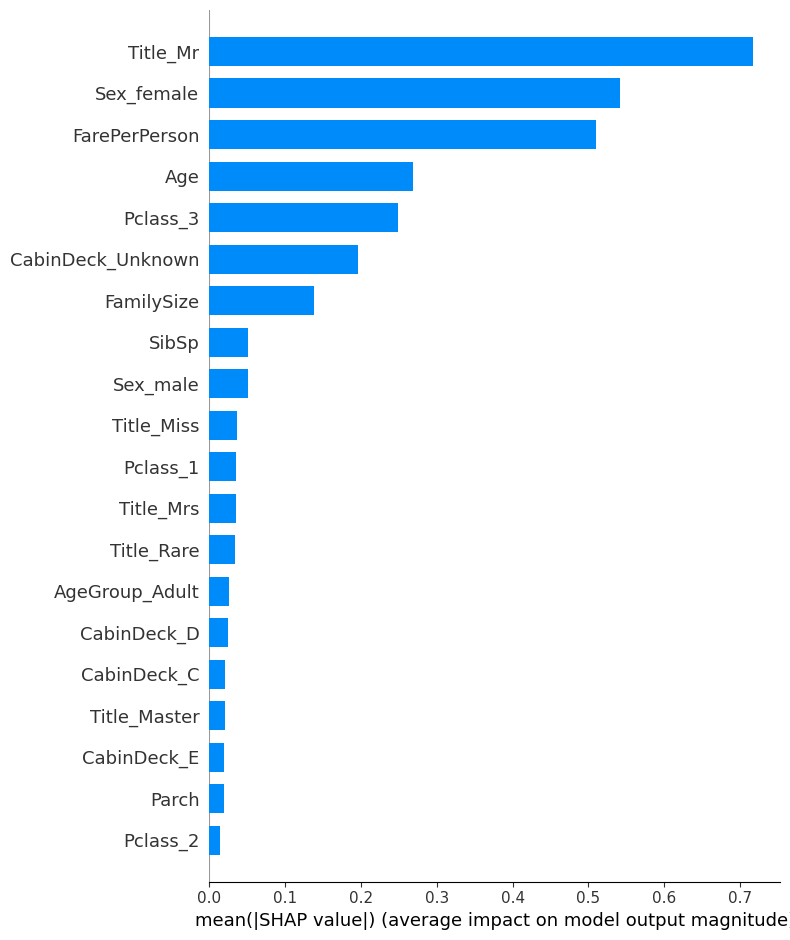

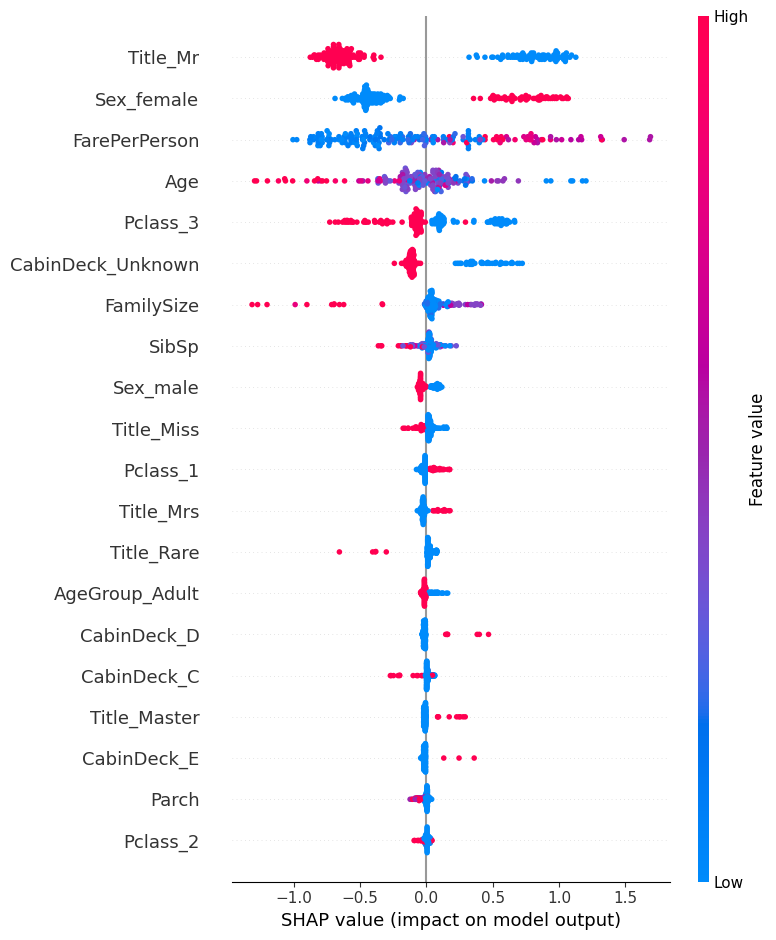

In [66]:
import shap
explainer = shap.TreeExplainer(xgb_final)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)
shap.summary_plot(shap_values, X_test, show=True)

En estas gráficas resumen de los valores SHAM, podemos ver más claramente que efecto tiene en los árboles de decisión cada valor.
Entre lo más interesante, está la clara distribución de edad que favorece estar joven, pero que en el medio, donde está el cruze 
entre sobrevivir o morir, también se ven los pasajeros con la edad mediana, con el color morado.

Y más revelador aún, es la diferencia entre Edad y Title_Mr, y la similitud (si inversa) entre ser mujer y Title_Mr. Edad claramente abarca todo el rango del impacto del modelo, pero Title_Mr y Sex Female no podrían estar más separados, los mejores indicadores de supervivencia para este modelo.

### SVM

#### Vectores de Soporte

In [67]:
# Modelo entrenado
svm = best_models["SVM"]

print("Número de vectores de soporte:", len(svm.support_))
print("Proporción de vectores de soporte:", len(svm.support_) / len(X_train))
print("Vectores de soporte por clase:", svm.n_support_)

Número de vectores de soporte: 443
Proporción de vectores de soporte: 0.6221910112359551
Vectores de soporte por clase: [221 222]


La cantidad de vectores de soporte es un poco preocupante, pues es casi la mitad de la cantidad de datos, pero considerando que varias de las variables están correlacionadas, probablemente hay otra configuración de features en la que se necesitan menos vectores y se puede entrenar un modelo más simple.

Aunque parecen muchos vectores, sigue siendo la configuración de hiperparámetros que se desmpeñó mejor en su ROC-AUC.

#### Impacto del kernel

In [69]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

kernels = ["linear", "rbf", "poly", "sigmoid"]
results = {}

for k in kernels:
    svm_k = SVC(kernel=k, probability=True, random_state=42)
    svm_k.fit(X_train, y_train)
    y_proba = svm_k.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    results[k] = auc

print("ROC-AUC por kernel:")
for k, auc in results.items():
    print(f"{k}: {auc:.3f}")

ROC-AUC por kernel:
linear: 0.853
rbf: 0.836
poly: 0.846
sigmoid: 0.724


#### Projección 2D

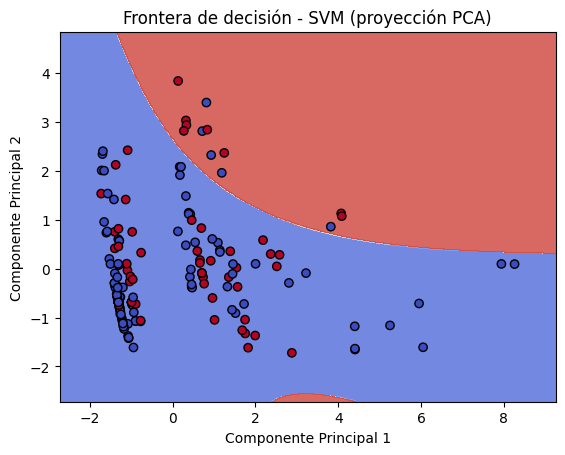

In [68]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA

# Proyección PCA a 2D
X_proj = PCA(n_components=2).fit_transform(X_test)

# Entrenar un SVM nuevo SOLO para visualización en 2D
svm_vis = SVC(kernel=svm.kernel, C=svm.C, gamma=svm.gamma, probability=True)
svm_vis.fit(X_proj, y_test)

# Crear malla para graficar
h = .02
x_min, x_max = X_proj[:, 0].min() - 1, X_proj[:, 0].max() + 1
y_min, y_max = X_proj[:, 1].min() - 1, X_proj[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svm_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Graficar frontera
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_proj[:, 0], X_proj[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors="k")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Frontera de decisión - SVM (proyección PCA)")
plt.show()

Las variables que hacen que el modelo funcione definitivamente no se ajustan muy bien cuando se intenta 
aplanar el modelo a solo dos dimensiones. La gráfica no dice mucho sobre como el modelo separa los datos...

## Guardar los modelos que mejor se desempeñaron:

In [23]:
import pickle
import os

os.makedirs("../models", exist_ok=True)

with open("../models/logistic_regression_final.pkl", "wb") as f:
    pickle.dump(best_models.get("Logistic Regression (l1/l2)"), f, protocol=5)

with open("../models/random_forest_final.pkl", "wb") as f:
    pickle.dump(best_models.get("Random Forest"), f, protocol=5)

with open("../models/xgboost_final.pkl", "wb") as f:
    pickle.dump(best_models.get("XGBoost"), f, protocol=5)

with open("../models/svm_final.pkl", "wb") as f:
    pickle.dump(best_models.get("SVM"), f, protocol=5) # Ahora si esta implementado

In [25]:
# Guardar el DataFrame df_fe (con todas las features y cambios) a un archivo CSV
df_fe.to_csv("../data/processed/titanic_dataset_features.csv", index=False)
print("Archivo 'titanic_dataset_features.csv' guardado exitosamente.")

Archivo 'titanic_dataset_features.csv' guardado exitosamente.
